C:\Users\thebe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5325 - loss: 0.8374 - val_accuracy: 0.7215 - val_loss: 2.8976 - learning_rate: 5.0000e-04
Epoch 2/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7089 - loss: 0.5737 - val_accuracy: 0.7237 - val_loss: 7.9306 - learning_rate: 5.0000e-04
Epoch 3/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7716 - loss: 0.4809 - val_accuracy: 0.7313 - val_loss: 8.0467 - learning_rate: 5.0000e-04
Epoch 4/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7959 - loss: 0.4353 - val_accuracy: 0.6891 - val_loss: 10.1215 - learning_rate: 5.0000e-04
Epoch 5/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8130 - loss: 0.4020 - val_accuracy: 0.6869 - val_loss: 11.7057 - learning_rate: 2.5000e-04
Epoch 6/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8237 - loss: 0.3844 - val_accuracy: 0.6613 - val_loss: 16.2656 - learning_rate: 2.5000e-04
Epoch 7/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accurac

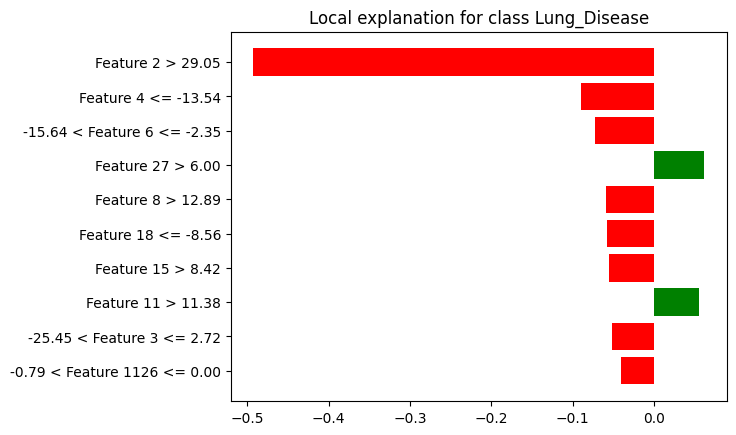

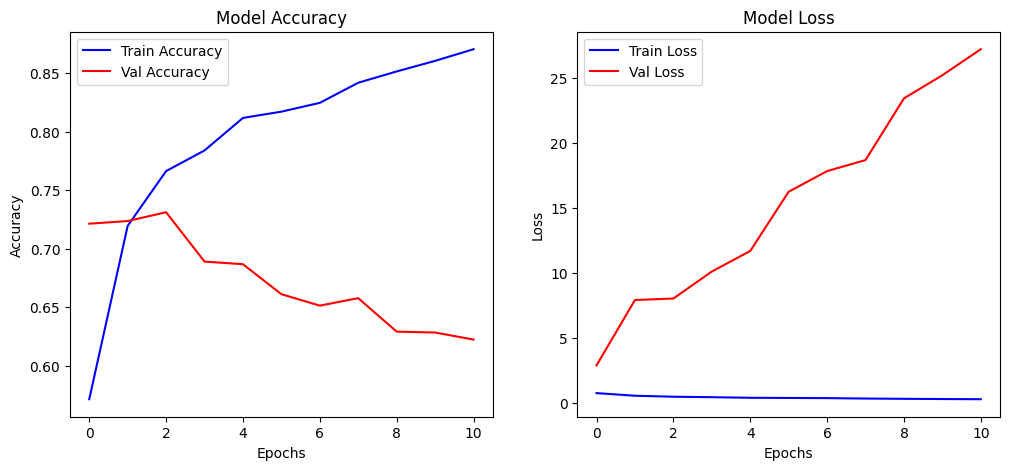

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.combine import SMOTETomek
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import lime
from lime.lime_tabular import LimeTabularExplainer

# Base path and augmentation config
base_path = '../Database/'
data, labels = [], []

data_gen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
    brightness_range=[0.8, 1.2], fill_mode='nearest'
)

# Load & augment images manually before HOG extraction
def load_images_from_folder(folder, label, augment_count=3):
    folder_path = os.path.join(base_path, folder)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))
        data.append(img)
        labels.append(label)

        # Augment
        img_rgb = np.stack([img] * 3, axis=-1)  # Grayscale to RGB
        img_rgb = np.expand_dims(img_rgb, axis=0)
        aug_iter = data_gen.flow(img_rgb, batch_size=1)
        for _ in range(augment_count):
            aug_img = next(aug_iter)[0][:, :, 0]  #   # Convert back to grayscale
            data.append(aug_img)
            labels.append(label)

# Load all categories
load_images_from_folder("Normal", "Normal")
for folder in ["Lung_Opacity", "Viral Pneumonia"]:
    load_images_from_folder(folder, "Lung_Disease")

data = np.array(data).astype('float32') / 255.0
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    data, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

# HOG feature extraction
def extract_hog_features(images):
    return np.array([hog(img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=False) for img in images])

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

# Combine HOG + Raw Pixel Features
X_train_combined = np.hstack((X_train.reshape(X_train.shape[0], -1), X_train_hog))
X_test_combined = np.hstack((X_test.reshape(X_test.shape[0], -1), X_test_hog))

# SMOTETomek for class balance
smote = SMOTETomek(random_state=42)
X_train_combined, y_train = smote.fit_resample(X_train_combined, y_train)

# Normalize features
scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_test_combined = scaler.transform(X_test_combined)

# Apply PCA
pca = PCA(n_components=0.95)
X_train_combined = pca.fit_transform(X_train_combined)
X_test_combined = pca.transform(X_test_combined)

# Dense neural network
def create_custom_dense_model_stronger(input_shape):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


model = create_custom_dense_model_stronger(X_train_combined.shape[1])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Add Gaussian noise to features
noise_factor = 0.05
X_train_noisy = X_train_combined + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_combined.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)

# Training
history = model.fit(X_train_noisy, y_train, validation_data=(X_test_combined, y_test),
                    epochs=50, callbacks=[lr_scheduler, early_stopping], batch_size=32)

# Evaluation
y_pred = (model.predict(X_test_combined) > 0.55).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# LIME Explainability
explainer = LimeTabularExplainer(
    X_train_combined,
    feature_names=["Feature " + str(i) for i in range(X_train_combined.shape[1])],
    class_names=["Normal", "Lung_Disease"],
    discretize_continuous=True
)

def lime_predict_fn(x):
    preds = model.predict(x)
    return np.hstack([1 - preds, preds])

exp = explainer.explain_instance(X_test_combined[0], lime_predict_fn, num_features=10)
exp.as_pyplot_figure()
plt.show()

# Plotting accuracy/loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Val Loss', color='red')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)
